In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import *

from matplotlib import pyplot as plt
from IPython import display

from typing import *
from utils import v2c
from utils.semeval2014 import tools as st
from utils.helper import *

ModuleNotFoundError: No module named 'sklearn'

In [3]:
class ABSACLSDataSet(Dataset):
    def __init__(self, items:st.ATSAItems, tokenizer:v2c.SimpleTokenizer):
        self.size = len(items)
        self.texts = [tokenizer.tokenize(i) for i in items.text]
        self.terms = [tokenizer.tokenize(i) for i in items.term]
        self.y = items.get_y()

    def __getitem__(self, idx):
        return self.texts[idx], self.terms[idx], self.y[idx]
    
    def __len__(self):
        return self.size
    
def pad(batch:List[List[int]], padding_val:int=0):
    """
    给一个batch中所有行补齐到batch最长长度
    """
    lens = list(map(len, batch))
    max_lens = max(map(len, batch))
    for i, j in enumerate(batch):
        j += [padding_val] * (max_lens - lens[i])
    return torch.LongTensor(batch), torch.LongTensor(lens)

def batch_pad(batch, padding_val:int=0): # 采集到的batch组成模型需要的输入形式
    texts = []
    terms = []
    y = []
    for i in batch:
        texts.append(i[0])
        terms.append(i[1])
        y.append(i[2])
    texts, texts_lens = pad(texts)
    terms, terms_lens = pad(terms)
    y = torch.LongTensor(y)
    return (texts, texts_lens, terms, terms_lens), y

In [4]:
def packed_RNN_forward(rnn:nn.Module, embedding:nn.Embedding, batch:torch.LongTensor, lens:torch.LongTensor):
    #print(type(rnn))
    assert rnn.batch_first == True #必须是batch在前面
    new_lens, idx = lens.sort(dim=0, descending=True) # 按长度降序排列
    _, re_idx = idx.sort(dim=0) #用于还原的索引
    batch = batch[idx] # 按长度下降顺序排列整个batch
    X = embedding(batch)
    packed_X = pack_padded_sequence(input=X, lengths=new_lens, batch_first=True) # 注意batch_first
    packed_out, h_n = rnn(packed_X) # 和普通的rnn返回值是一样的, output, h_n
    out, _ = pad_packed_sequence(packed_out, batch_first=True) # 只有output是被压缩的
    return torch.index_select(out, 0, re_idx), h_n # 还原输出, 并保持

In [4]:
class ABSACLSLSTMModel(nn.Module):
    '''
    用于ATSA任务或ACSA任务，使用LSTM分别建模上下文和term(或category)，
    再将两者的h_n拼接再一起使用全连接网络
    '''
    def __init__(self, weights:np.ndarray, text_hidden_size:int, text_num_layers:int, 
                 term_hidden_size:int, term_num_layers:int, fc_hidden_size:int,
                 output_size:int, freeze_embedding=False, # 固定词向量
                 text_bidirectional:bool=False, text_dropout:float=0.,
                 term_bidirectional:bool=False, term_dropout:float=0.,
                 fc_dropout=0.
                ):
        super(ABSACLSLSTMModel, self).__init__()
        self.input_size = weights.shape[1] # 输入维度
        self.word_embedding = nn.Embedding.from_pretrained(torch.from_numpy(weights)) 
        self.word_embedding.weight.requires_grad = not freeze_embedding # 是否固定词向量
        
        self.text_lstm = nn.LSTM(input_size=self.input_size, hidden_size=text_hidden_size,
                                num_layers=text_num_layers,
                                bidirectional=text_bidirectional, 
                                batch_first=False,
                                dropout=text_dropout)
        self.term_lstm = nn.LSTM(input_size=self.input_size, hidden_size=term_hidden_size,
                                num_layers=term_num_layers,
                                bidirectional=term_bidirectional, 
                                batch_first=False,
                                dropout=term_dropout)
        
#         self.fc = nn.Linear(text_hidden_size * (2 if text_bidirectional else 1) * text_num_layers +
#                            term_hidden_size * (2 if term_bidirectional else 1) * term_num_layers,
#                             fc_hidden_size)
        
#        self.fc_relu = nn.ReLU()
#        self.fc_dropout = nn.Dropout(fc_dropout)
#        self.output = nn.Linear(fc_hidden_size, output_size)
        self.output = nn.Linear(text_hidden_size * (2 if text_bidirectional else 1) * text_num_layers +
                            term_hidden_size * (2 if term_bidirectional else 1) * term_num_layers, output_size)
        
    def forward(self, X):
        texts, texts_lens, terms, terms_lens = X
#         text_output, (text_hn, text_cn) = packed_RNN_forward(self.text_lstm, self.word_embedding, 
#                                                                texts, texts_lens)
        
#         terms_output, (term_hn, term_cn) = packed_RNN_forward(self.term_lstm, self.word_embedding, 
#                                                                 terms, terms_lens)
        #print(text_hn.shape, term_hn.shape)
        # h_n, c_n (hidden_layers * , batch_size, hidden_size)
        texts, terms = self.word_embedding(texts), self.word_embedding(terms)
        
        texts = texts.permute((1, 0, 2)).contiguous()
        terms = terms.permute((1, 0, 2)).contiguous()
        
        _, (text_hn, __) = self.text_lstm(texts)
        _, (term_hn, __) = self.term_lstm(terms)
        
        text_hn = text_hn.permute((1, 0, 2)).contiguous() # 后面需要变形所以要保证内存连续
        term_hn = term_hn.permute((1, 0, 2)).contiguous()
        #print(text_hn.shape, term_hn.shape)
        text_hn = text_hn.view(text_hn.shape[0], -1)
        term_hn = term_hn.view(term_hn.shape[0], -1)
        
        fc_in = torch.cat((text_hn, term_hn), dim=1) # 拼接
        #print(fc_in.shape)
#         fc_output = self.fc(fc_in) # 全连接
#        fc_output = self.fc_relu(fc_in) # 激活函数
#        fc_output = self.fc_dropout(fc_output) # dropout
        output = self.output(fc_in)
        return output

In [6]:
%%time 
# 测试模型是否行得通
def test():
    vocab_size, d = 5, 3 
    weights = np.ones((vocab_size, 3))
    weights = v2c.get_embedding_weights(weights) # 填加一行0在0处， 添加一行unk在-1处
    #print(weights)
    text_hidden_size, text_num_layers = 10, 2
    term_hidden_size, term_num_layers = 8, 1
    fc_hidder_size, output_size = 64, 3
    model = ABSACLSLSTMModel(weights, text_hidden_size, text_num_layers,
                            term_hidden_size, term_num_layers, fc_hidder_size, output_size)
    #print(model)
    texts = torch.LongTensor([[1, 2, 3, 4], 
                             [1, 6, 0, 0],
                             [5, 0, 0, 0],
                             [3, 4, 1, 0],
                             [2, 3, 4, 5]])
    texts_lens = torch.LongTensor([4, 2, 1, 3, 4])
    
    terms = torch.LongTensor([[1, 2, 0],
                             [1, 3, 4],
                             [2, 0, 0],
                             [5, 6, 1],
                             [2, 0, 0]])
    terms_lens = torch.LongTensor([2, 3, 1, 3, 1])
    
    t_embd = nn.Embedding.from_pretrained(torch.from_numpy(weights))
    #indices = torch.LongTensor([3, 4, 5, 6, -1]) embedding不支持使用-1去索引
    #print(t_embd(indices))
    #print(t_embd(text))
    #print(model.word_embedding(text))
    
    #text_lstm = nn.LSTM(d, text_hidden_size, text_num_layers, batch_first=True)
    #term_lstm = nn.LSTM(d, term_hidden_size, term_num_layers, batch_first=True)
    #print(type(text_lstm))
    #X = t_embd(texts)
    #output, (h_n, c_n) = text_lstm(X)
    #X = t_embd(terms)
    #output, (h_n, c_n) = term_lstm(X)
    #print(output.shape, h_n.shape, c_n.shape)
    print(model((texts, texts_lens, terms, terms_lens)))
    #print(predict(model, (texts, texts_lens, terms, terms_lens)))
#test()

SyntaxError: invalid syntax (<string>, line 1)

In [7]:
def predict(model:nn.Module, batch:tuple) -> torch.Tensor:
    res = model(*batch)
    y = res.argmax(dim=1)
    return y
def to_cuda(var):
    if isinstance(var, torch.Tensor):
        return var.cuda()
    else:
        return tuple(to_cuda(i) for i in var) # 递归下去

    
def _draw(train_loss:List[float], test_loss:List[float], 
          test_acc:List[float], test_f1:List[float], figsize:Tuple[int, int]=(16, 6)):

    plt.figure(12, figsize=figsize)
    
    def plot(vals, color, label):
        x = list(range(len(vals)))
        y = vals
        plt.plot(x, y, c=color, label=label)
        
    plt.subplot(121)
    plot(train_loss, "red", "Train loss")
    plot(test_loss, "blue", "Test loss")
    plt.xlabel("Batches")
    plt.title("Loss")
    
    #if not only_test:
    #    plt.plot(epoches, train_acc, c="red", label="Train accuracy")
    #    plt.plot(epoches, train_f1, c="purple", label="Train f1")
    plt.subplot(122)
    plot(test_acc, "green", "Test accuracy")
    plot(test_f1, "blue", "Test f1")
    plt.xlabel("Epoches")
    plt.title("Accuracy and F1")
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

def train(writer:SummaryWriter, model:nn.Module, optimizer:torch.optim.Optimizer, loss:Callable,
          train_dataloader:DataLoader, test_dataloader:DataLoader, 
          num_epoches:int, use_cuda:bool=True, draw:bool=True):
    train_loss = [0.]
    test_loss = [0.]
    test_acc = [0.]
    test_f1 = [0.]
    all_y_pred = []
    all_y_true = []
    for i in range(num_epoches):
        #train
        model.train()
        for X, y in train_dataloader:
            if use_cuda:
                X, y = to_cuda((X, y))
            res = model(X)
            l = loss(res, y)
            train_loss.append(l.item())
            if len(train_loss) % 10 == 1:
                writer.add_scalar("Train_loss", train_loss[-1], len(train_loss)) # 打印loss
            if draw:
                _draw(train_loss, test_loss, test_acc, test_f1)
            #反向传播
            optimizer.zero_grad()
            l.backward()
#             if grad_clip:
#                 nn.utils.clip_grad_norm_(net.parameters(), max_norm=20, norm_type=2)
            optimizer.step()
        #eval
        with torch.no_grad():
            model.eval()
            y_pred = []
            y_true = []
            for X, y in test_dataloader:
                y_true += list(y.cpu().view(-1))#真实标签
                if use_cuda:
                    X, y = to_cuda((X, y))
                res = model(X)
                l = loss(res, y)
                test_loss.append(l.item())
                if len(test_loss) % 10 == 1:
                    writer.add_scalar("Test_loss", test_loss[-1], len(test_loss)) # 打印loss
                if draw:
                    _draw(train_loss, test_loss, test_acc, test_f1)
                y_pred += list(res.argmax(dim=1).cpu().view(-1)) # 预测的标签
                all_y_pred.append(y_pred)
                all_y_true.append(y_true)
        acc, f1 = st.classifer_evaluate(y_true, y_pred) # 计算acc 和 f1
        test_acc.append(acc)
        test_f1.append(f1)
        writer.add_scalar("Test_accuracy", test_acc[-1], len(test_acc))
        writer.add_scalar("Test_f1", test_f1[-1], len(test_f1))
        if draw:
            _draw(train_loss, test_loss, test_acc, test_f1)
    return train_loss, test_loss, test_acc, test_f1, all_y_pred, all_y_true

In [7]:
# %%time
# #测试
# #加载初始化权重
# #vocab, weights = v2c.load_glove()
# vocab = v2c.load_vocab()
# weights = np.ones((len(vocab), 3), dtype=np.float32)
# weights = v2c.get_embedding_weights(weights)
# print(weights.shape, weights.dtype)
# tokenizer = v2c.SimpleTokenizer(vocab)

# text_hidden_size, text_num_layers = 5, 2
# term_hidden_size, term_num_layers = 4, 1
# fc_hidden_size, output_size = 32, 3
# model = ABSACLSLSTMModel(weights, text_hidden_size, text_num_layers, term_hidden_size, term_num_layers, 
#                          fc_hidden_size, output_size, text_bidirectional=True, text_dropout=0.5, term_dropout=0.5, fc_dropout=0.5)
# model

In [8]:
rest_train_path = "./dataset/semeval2014/Restaurants_Train_v2.xml"
rest_test_path = "./dataset/semeval2014/Restaurants_Test_Gold.xml"
lap_train_path = "./dataset/semeval2014/Laptop_Train_v2.xml"
lap_test_path = "./dataset/semeval2014/Laptops_Test_Gold.xml"
rest_train = st.Semeval2014DataSet(rest_train_path)
rest_ATSA_train_items = rest_train.get_ATSAItems()
rest_test = st.Semeval2014DataSet(rest_test_path)
rest_ATSA_test_items = rest_test.get_ATSAItems()

In [9]:
%%time
#加载初始化权重
vocab = v2c.load_vocab()
weights = np.random.uniform(-0.1, 0.1, (len(vocab), 10))
#vocab, weights = v2c.load_glove()
weights = v2c.get_embedding_weights(weights)
print(weights.shape, weights.dtype)
tokenizer = v2c.SimpleTokenizer(vocab)

SyntaxError: invalid syntax (<string>, line 1)

In [10]:
batch_size = 256
rest_ATSA_train_dataset = ABSACLSDataSet(rest_ATSA_train_items, tokenizer)
rest_ATSA_test_dataset = ABSACLSDataSet(rest_ATSA_test_items, tokenizer)
train_data = DataLoader(rest_ATSA_train_dataset, batch_size=batch_size, num_workers=8, shuffle=True,  collate_fn=batch_pad)
#测试集不能打乱
test_data = DataLoader(rest_ATSA_test_dataset, batch_size=batch_size, num_workers=8, shuffle=False,  collate_fn=batch_pad) 

In [11]:
text_hidden_size, text_num_layers = 20, 1
term_hidden_size, term_num_layers = 20, 1
fc_hidden_size, output_size = 40, 3
model = ABSACLSLSTMModel(weights, text_hidden_size, text_num_layers, term_hidden_size, term_num_layers, 
                         fc_hidden_size, output_size, text_bidirectional=True, text_dropout=0.5, term_dropout=0.5, fc_dropout=0.5)
print(model)
torch.cuda.set_device(1)
model = model.cuda()
loss = nn.CrossEntropyLoss()

/home/ly/miniconda3/envs/torch1.1.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


ABSACLSLSTMModel(
  (word_embedding): Embedding(400002, 10)
  (text_lstm): LSTM(10, 20, dropout=0.5, bidirectional=True)
  (term_lstm): LSTM(10, 20, dropout=0.5)
  (fc_relu): ReLU()
  (fc_dropout): Dropout(p=0.5)
  (output): Linear(in_features=60, out_features=3, bias=True)
)


CPU times: user 1min 18s, sys: 4.36 s, total: 1min 22s
Wall time: 1min 22s


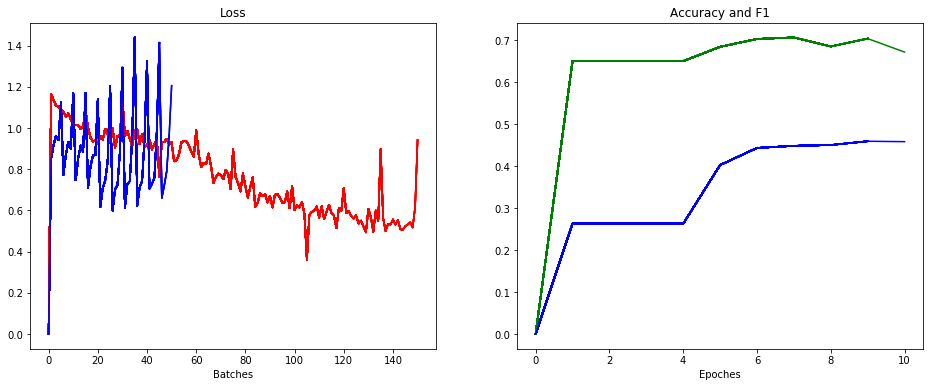

In [15]:
%%time
writer = time_writer()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.003, amsgrad=True)
train_loss, test_loss, test_acc, test_f1, y_pred, y_true= train(writer, model, optimizer, loss, train_data, test_data, 10)
torch.cuda.empty_cache()

In [13]:
t1 = torch.tensor(y_true[0])
t2 = torch.tensor(rest_ATSA_test_items.get_y())

NameError: name 'y_true' is not defined

In [ ]:
t1.sum(), len(t1)